In [1]:
import os, sys

os.chdir('e:\Downloads (E)\@Books\@TPM\@PDPC\@data_analysis\model_build')
sys.path.append('e:\Downloads (E)\@Books\@TPM\@PDPC\@data_analysis\model_build')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker as ticker  ## special scaling stuff
import cmasher as cmr
import colorcet as cet
from importlib import reload  ## for reloading packages
import pickle
import OFM_postprocess_scripts as post
from importlib import reload

In [3]:
# retrieve files from saved pickles
model_vers = 'v6'
exps_batchname = 'Policies' # was 'Policies'


exps_filename = f'model{model_vers}_exps_{exps_batchname}_'
exps_s = post.read_experiments_from_pickle(f'data_output/{exps_filename}.pickleobject')
# extract relevant meta-information from pickled experiment object
meta_s = pd.DataFrame.from_dict(exps_s.results_metadata, orient='index')




In [4]:

# fill in placeholder value for flightbans of None
meta_s['p_FlightBans'] = meta_s['p_FlightBans'].fillna(value=500).astype(int)
meta_s['p_FlightBans_nom'] = meta_s['p_FlightBans'] - exps_s.c_nominal_ref_date
results_s: pd.DataFrame = post.add_extra_metrics(exps_s)

# invert the policy inputs to be relative again (more human-readable)
policy_inputs = dict((v, k) for k, v in exps_s.p_flightbans_map.items())  # inversion process
exps_s.results_verbose = exps_s.results_postprocess = None

In [5]:
# # Only use with 'Policies and Indirect' set
# subsect_r = [1.3,]
# subsect_bans = [-2, -1, 0, 1, 2, 7, 14] # in relative form from 26 Nov
# subsect_indirect = [0, 0.1,]
#
# # need to restrict the policy inputs
# policy_inputs = dict([(d, policy_inputs[d]) for d in subsect_bans])
# # need to subsection the results DF
# # results_subsect = results_s[results_s]
# # might want to change the colours of week
# meta_s = meta_s[meta_s['p_FlightBans'].isin(policy_inputs.values()) &
#                    meta_s['u_Rzero'].isin(subsect_r) &
#                    meta_s['u_ImportsIndirect'].isin(subsect_indirect)]
# results_s = results_s[results_s['exp_id'].isin(meta_s.index)]


# Goal
Make graph of time to 10k (via truncation)


# cumulative plot
make title
not include all lines
change hue to specific colours
y axis to cumulative, with formatting
change the legend to be exact


In [6]:
## Colour palette
# Pre-defined colours for week 1 and 2
palette = {
    500: 'lightsteelblue',
    7: 'lightpink',
}
# Get remainder of the policies
_remain = set(policy_inputs.keys()) - set(palette.keys())
# Create a discrete colour palette from Cmasher's function
_subpalette = cmr.get_sub_cmap('cet_rainbow4',#'cmr.guppy_r',
                               start=0.25,
                               stop=1.,
                               N=len(_remain))
# Add discrete colours with associated points into the palette for later use
palette.update(dict((pol, c) for pol, c in zip(sorted(_remain), _subpalette.colors)))



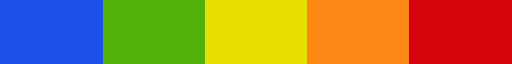

In [7]:
cmr.get_sub_cmap('cet_rainbow4',#'cmr.guppy_r',
                               start=0.25,
                               stop=1.,
                               N=len(_remain))

In [8]:
# to check numerical results at 10k
numerical = results_s.pivot(
    values='cum_infected',
    index='elapsed_nominal',
    columns='exp_id',
).apply(np.searchsorted, axis=0,
        v=10000, side='left') - exps_s.c_nominal_ref_date

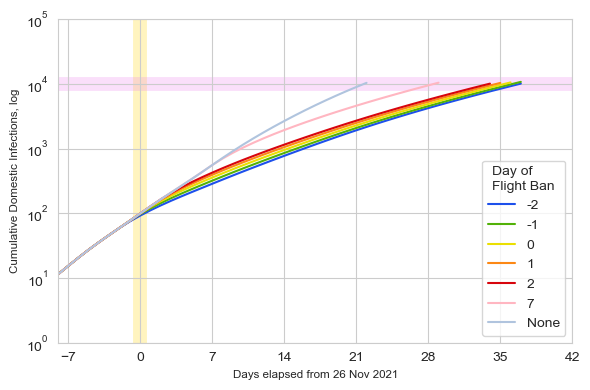

In [9]:
# Make plot
# Jaarcongres settings; figsize (5.7, 5.05) or jaarcongres2 = (5.7, 2.1) (narrower aspect ratio)
save_name = 'RQ1 Time to 10k Cumulative'
_addon2 = 'manuscript'  # changing plot aspect ratio for manuscipt/presentation/etc.
fig, ax = plt.subplots(figsize=(6, 4))

# _addon2 = 'jaarcongres'  # changing plot aspect ratio for manuscipt/presentation/etc.
# fig, ax = plt.subplots(figsize=(5.7, 2.1))


sns.lineplot(data=results_s,
             x='elapsed_nominal',
             y='cum_infected',
             hue='p_FlightBans_nom',
             legend='full',
             palette=palette,
             ax=ax)


# small tweaks for nicer plot
plt.ylim((0, 10000))
plt.xlim((-8, 42))  # was -14
h, l = ax.get_legend_handles_labels()

# # **
# l[l.index('p_FlightBans_nom')] = 'Flight Ban'
# l[l.index('u_ImportsIndirect')] = 'Indirect Imports %'
l[l.index('500')] = 'None'
legend_title = 'Day of\nFlight Ban'
ax.legend(handles=h,
          labels=l,
          title=legend_title,
          loc='center left',
          bbox_to_anchor=(1.03, 0.5),
          frameon=False,
          fontsize='small')  ## TODO: bbox, fontsize
ax.set_ylabel('Cumulative Local Infections', fontsize='small') ## TODO: fontsize
ax.set_xticks(range(-7, 43, 7))
ax.set_xlabel('Days elapsed from 26 Nov 2021', fontsize='small')  ## TODO:fontsize
_addon = '(linear plot)'
_title = 'Effect of day of flight ban on\n' \
         'time to 10.000 cumulative domestic cases\n' \
         'with R0 = 1.3'
# ax.set_title(f'{_title}, {_addon}')
ax.axvline(0, c='gold', linewidth=10, zorder=0.1, alpha=0.25)
# Output to graph
plt.tight_layout()
# REACTIVATE FROM THIS POINT
plt.savefig(f'output_figures/{model_vers}/{model_vers}_{exps_batchname},{save_name},{_addon},{_addon2}.jpg', dpi=300)

## Change axes to log presentation
plt.yscale('log')
plt.ylim(1, 100000)
ax.set_ylabel('Cumulative Domestic Infections, log')
_addon = '(log plot)'
# ax.set_title(f'{_title}, {_addon}')
ax.axhline(10000, c='violet', linewidth=10, zorder=0.1, alpha=0.25)
# h, l = ax.get_legend_handles_labels()
# ** addendum
# legend_order = [0,7,6,5,4,3,2,1,8,9,10]
# h = [h[o]for o in legend_order]
# l = [l[o] for o in  legend_order]
ax.legend(handles=h, labels=l, title=legend_title)  # **, previously was reversed()

plt.tight_layout()
plt.savefig(f'output_figures/{model_vers}/{model_vers}_{exps_batchname},{save_name},{_addon}, {_addon2}.jpg', dpi=300)

In [ ]:
# Same plot but subplots now
save_name = 'RQ1 Time to 10k Cumulative'
fig, ax = plt.subplots(figsize=(5, 6), nrows=2,
                       sharex=True)
for idx, subax in enumerate(ax):
    if idx + 1 == ax.size:
        legend_state = 'full'
    else:
        legend_state = None
    sns.lineplot(data=results_s,
                 x='elapsed_nominal',
                 y='cum_infected',
                 hue='p_FlightBans_nom',
                 legend=legend_state,
                 palette=palette,
                 ax=subax)
    subax.axvline(0, c='pink', linewidth=10, zorder=0.1, alpha=0.35)

# small tweaks for nicer plot
subax0, subax1 = ax
subax0.xaxis.set_tick_params(labelbottom=True)  # needed for redrawing the x-axis after sharex=True in subplots function
subax0.set_ylim((0, 10000))
subax0.set_xlim((-14, 56))
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=h,
#           labels=l,
#           title=legend_title)
subax0.set_ylabel('Cumulative Domestic Infections')
subax0.set_xticks(range(-14, 57, 7))
_addon = '(linear plot)'
_title = 'Effect of day of flight ban on\n' \
         'time to 10.000 cumulative domestic cases\n' \
         'with R0 = 1.3'
# subax0.set_title(f'{_title}, {_addon}')

# Output to graph
# plt.tight_layout()

# plt.savefig(f'output_figures/v5/v5_{exps_batchname},{save_name},{_addon}.jpg', dpi=300)


## Change axes to log presentation
subax1.set_yscale('log')
subax1.set_ylim(1, 30000)
subax1.set_xlabel('Days elapsed from 26 Nov 2021')
subax1.set_ylabel('Cumulative Domestic Infections, log')
subax1.axhline(10000, c='lime', linewidth=10, zorder=0.1, alpha=0.15)

legend_title = 'Day of Flight Ban'
h, l = subax1.get_legend_handles_labels()
# loc: anchor/datum on legend
# bbox: location from fig to anchor
# note use of fig instead of ax
fig.legend(handles=h, labels=l, title=legend_title,
           loc='lower center', bbox_to_anchor=(0.5, 1), frameon=True, ncols=len(h),
           fontsize='8')
subax1.get_legend().remove() # remove original subplot ax (we only needed it for getting plot information.

plt.tight_layout()
plt.savefig(f'output_figures/{model_vers}/{model_vers}_{exps_batchname},{save_name},2panel.jpg', dpi=300)

In [10]:
daysearch_piv = results_s.pivot(
    values='cum_infected',
    index='elapsed_nominal',
    columns='exp_id',
)
meta_s['days_10k_cumulative'] = daysearch_piv.apply(np.searchsorted, axis=0, v=10000,
                                                    side='left') - exps_s.c_nominal_ref_date


<AxesSubplot: xlabel='p_FlightBans_nom', ylabel='days_10k_cumulative'>

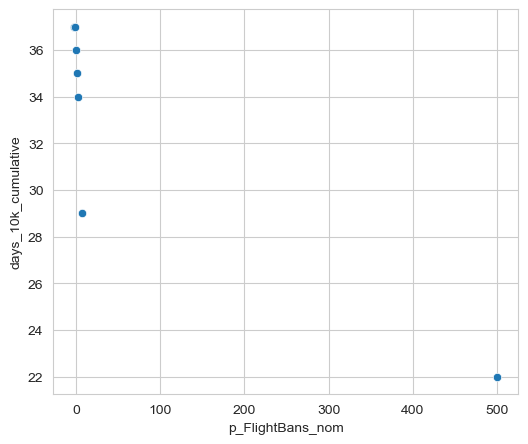

In [11]:
fig, ax = plt.subplots(figsize=(6, 5))
plot_data = meta_s
sns.scatterplot(plot_data,
                x='p_FlightBans_nom',
                y='days_10k_cumulative',
                ax=ax
                )